# Visualize Model Coefficients

**Gregory Way, 2019**

In [1]:
suppressPackageStartupMessages(library(dplyr))
suppressPackageStartupMessages(library(ggplot2))
suppressPackageStartupMessages(library(cowplot))
suppressPackageStartupMessages(library(ggrepel))

In [2]:
consensus <- "modz"

In [3]:
coef_dir <- file.path("figures", "coefficients")
figure_dir <- file.path(coef_dir, consensus)
results_dir <- "results"

dir.create(figure_dir, recursive = TRUE, showWarnings = FALSE)

## Load Function

In [4]:
coef_plot <- function(
    df, target_name, compartment_features, coef_theme, top_plot_num = 15
) {
    # Compile a series of plots that describe model coefficients
    #
    # Arguments:
    # df - coefficient dataframe with feature metadata and weights
    # target_name - a string of a specific cell health model
    # compartment_features - a vector of which features to plot
    # coef_theme - a ggplot theme object to apply to all plots
    # top_plot_num - the number of top individual features to visualize
    
    # Subset the input dataframe to focus on the specific target
    subset_coef_df <- coef_df %>% dplyr::filter(target == !!target_name)

    # Extract and process specific feature sets
    area_df <- subset_coef_df %>%
        dplyr::filter(feature_group %in% c("AreaShape", "Neighbors")) %>%
        dplyr::group_by(shuffle, compartment, feature_group) %>%
        dplyr::top_n(n = 1, wt = abs_weight) %>%
        dplyr::group_by(compartment, feature_group, shuffle) %>%
        dplyr::mutate(abs_max_weight = max(abs_weight)) %>%
        dplyr::select(compartment, feature_group, shuffle, abs_max_weight) %>%
        dplyr::distinct()

    compartment_df <- subset_coef_df %>%
        dplyr::filter(feature_group %in% !!compartment_features) %>%
        dplyr::group_by(shuffle, compartment, feature_group, channel) %>%
        dplyr::top_n(n = 1, wt = abs_weight) %>%
        dplyr::group_by(compartment, feature_group, channel, shuffle) %>%
        dplyr::mutate(abs_max_weight = max(abs_weight)) %>%
        dplyr::select(compartment, feature_group, channel, shuffle, abs_max_weight) %>%
        dplyr::distinct()

    correlation_df <- subset_coef_df %>%
        dplyr::filter(feature_group == "Correlation") %>%
        dplyr::group_by(channel, parameter1, compartment, shuffle) %>%
        dplyr::mutate(abs_max_weight = max(abs_weight)) %>%
        dplyr::select(channel, parameter1, compartment, shuffle, abs_max_weight) %>%
        dplyr::distinct()

    # Process individual feature name info
    total_features <- length(unique(subset_coef_df$feature))
    total_non_zero_features <- nrow(
        subset_coef_df %>%
            dplyr::filter(shuffle == "Real") %>%
            dplyr::filter(abs_weight > 0)
        )
    
    top_plot_num <- ifelse(total_non_zero_features < top_plot_num,
                           total_non_zero_features,
                           top_plot_num)
    
    feature_title <- paste0(
        round((total_non_zero_features / total_features) * 100, 2),
        "% Non-Zero"
    )

    top_n_features <- subset_coef_df %>%
        dplyr::filter(shuffle == "Real") %>%
        dplyr::top_n(n = top_plot_num, wt = abs_weight) %>%
        dplyr::pull(feature)

    feature_order <- subset_coef_df %>%
        dplyr::filter(shuffle == "Real") %>%
        dplyr::arrange(weight) %>%
        dplyr::pull(feature)

    subset_coef_features_df <- subset_coef_df %>%
        dplyr::filter(shuffle == "Real") %>%
        dplyr::filter(feature %in% !!top_n_features)

    subset_coef_features_df$feature <- factor(
        subset_coef_features_df$feature, levels = feature_order
    )

    min_gradient <- min(subset_coef_df$abs_weight)
    max_gradient <- max(subset_coef_df$abs_weight)

    # 1st Plot - Area Features
    area_gg <- ggplot(area_df,
                      aes(x = compartment, y = feature_group)) +
        geom_point(aes(fill = abs_max_weight), size = 4, pch = 21) +
        facet_wrap(~shuffle) +
        scale_fill_gradientn(
            name = "Max\nAbs. Weight",
            colours = terrain.colors(10),
            limits = c(min_gradient, max_gradient)
        ) +
        ylab("Feature Group") +
        xlab("Compartment") +
        theme(axis.text.y = element_text(angle = 90, hjust = 0.5)) +
        theme_bw() +
        coord_fixed() +
        geom_text(aes(label = round(abs_max_weight, 2)), size = 1.5) +
        coef_theme +
        theme(axis.text.x = element_text(angle = 45, hjust = 1))

    # 2nd Plot - Other Compartment Features
    compartment_gg <- ggplot(compartment_df,
                             aes(x = channel, y = feature_group)) +
        geom_point(aes(fill = abs_max_weight), size = 4, pch = 21) +
        facet_grid(compartment~shuffle) +
        scale_fill_gradientn(
            name = "Max\nAbs. Weight",
            colours = terrain.colors(10),
            limits = c(min_gradient, max_gradient)
        ) +
        ylab("Feature Group") +
        xlab("Channel") +
        coord_fixed() +
        theme_bw() +
        geom_text(aes(label = round(abs_max_weight, 2)), size = 1.5) +
        coef_theme +
        theme(axis.text.x = element_text(angle = 90))

    # 3rd Plot - Correlation Features
    correlation_gg <- ggplot(correlation_df, aes(x = channel, y = parameter1)) +
        geom_point(aes(fill = abs_max_weight), size = 4, pch = 21) +
        facet_wrap(~shuffle) +
        scale_fill_gradientn(
            name = "Max\nAbs. Weight", 
            colours = terrain.colors(n_terrain_colors),
            limits = c(min_gradient, max_gradient)
        ) +
        ylab("Channel Correlation") +
        xlab("Channel Correlation") +
        facet_grid(~compartment) + 
        coord_fixed() +
        geom_text(aes(label = round(abs_max_weight, 2)), size = 1.5) +
        theme_bw() +
        coef_theme +
        theme(axis.text.x = element_text(angle = 90, hjust = 0.5)) +
        facet_grid(compartment~shuffle) 

    # 4th Plot - Individual Feature Names
    feature_name_gg <- ggplot(subset_coef_features_df,
                              aes(x = feature, y = weight)) +
        geom_bar(fill = "#8DB495", color = "black", stat = "identity") +
        ggtitle(feature_title) +
        coord_flip() +
        xlab("") +
        ylab("Model Coefficient") +
        theme_bw() +
        coef_theme

    # Get cowplot title
    use_title <- label_df %>%
        dplyr::filter(id == !!target) %>%
        dplyr::pull(readable_name)

    full_title <- ggdraw() + 
      draw_label(
          use_title,
          fontface = 'bold',
          x = 0,
          hjust = -0.1
      )
    coef_legend <- cowplot::get_legend(correlation_gg)

    right_panel <- cowplot::plot_grid(
        area_gg + theme(legend.position = "none",
                        plot.margin = margin(1, 1, 1, 1)),
        cowplot::plot_grid(
            correlation_gg + theme(legend.position = "none",
                                   plot.margin = margin(1, 1, 1, 1)),
            compartment_gg + theme(legend.position = "none",
                                   plot.margin = margin(1.3, 1, 1, 1)),
            nrow = 2,
            align = "vh",
            axis = "1"
        ),
        rel_heights = c(0.2, 1),
        nrow = 2,
        align = "none"
    )

    full_panel <- cowplot::plot_grid(
        feature_name_gg + theme(plot.margin = margin(1, 1, 1, 1)),
        right_panel,
        align = "none"
    )

    coef_full_gg <- cowplot::plot_grid(
        full_panel,
        coef_legend,
        rel_widths = c(1, 0.1)
    )
    
    coef_full_gg <- cowplot::plot_grid(
        full_title,
        coef_full_gg,
        nrow = 2,
        rel_heights = c(0.1, 1)
        )
    
    return(coef_full_gg)
}

## Load Data and Process Feature Info

In [5]:
# Annotated Cell Health Features
feat_file <- file.path(
    "..",
    "1.generate-profiles",
    "data",
    "labels",
    "feature_mapping_annotated.csv"
)

label_df <- readr::read_csv(feat_file, col_types = readr::cols())

In [6]:
# Load Regression Results
regression_file <- file.path(
    results_dir, 
    paste0("full_cell_health_regression_", consensus, ".tsv.gz")
)

regression_metrics_df <- readr::read_tsv(regression_file, col_types = readr::cols()) %>%
    dplyr::filter(cell_line == "all", metric == "r_two", data_fit == "test")

regression_metrics_df$shuffle <- dplyr::recode(
    regression_metrics_df$shuffle,
    "shuffle_true" = "Permuted",
    "shuffle_false" = "Real"
)
regression_metrics_df$shuffle <- factor(
    regression_metrics_df$shuffle,
    levels = c("Real", "Permuted")
)

print(dim(regression_metrics_df))
head(regression_metrics_df)

[1] 140   7


value,metric,target,data_fit,shuffle,y_transform,cell_line
<dbl>,<chr>,<chr>,<chr>,<fct>,<chr>,<chr>
0.03051071,r_two,cc_all_high_h2ax,test,Permuted,raw,all
0.32904702,r_two,cc_all_high_h2ax,test,Real,raw,all
-0.28888256,r_two,cc_all_large_notround_polynuclear_mean,test,Permuted,raw,all
0.23945727,r_two,cc_all_large_notround_polynuclear_mean,test,Real,raw,all
-0.20476805,r_two,cc_all_large_round_polyploid_mean,test,Permuted,raw,all
-0.39262788,r_two,cc_all_large_round_polyploid_mean,test,Real,raw,all


In [7]:
coef_file <- file.path(
    "results", paste0("full_cell_health_coefficients_", consensus, ".tsv.gz")
)

coef_df <- readr::read_tsv(
    coef_file,
    col_types = readr::cols(
        feature = readr::col_character(),
        weight = readr::col_double(),
        abs_weight = readr::col_double(),
        target = readr::col_character(),
        y_transform = readr::col_character(),
        shuffle = readr::col_character()
    )
) %>%
    dplyr::filter(y_transform == "raw") %>%
    tidyr::separate(
        feature,
        into = c(
            "compartment",
            "feature_group",
            "measurement",
            "channel", 
            "parameter1", 
            "parameter2"
        ),
        sep = "_",
        remove = FALSE
    )

coef_df$shuffle <- dplyr::recode(
    coef_df$shuffle,
    "shuffle_true" = "Permuted",
    "shuffle_false" = "Real"
)
coef_df$shuffle <- factor(
    coef_df$shuffle,
    levels = c("Real", "Permuted")
)

print(dim(coef_df))
head(coef_df, 5)

Warning message:
“Expected 6 pieces. Missing pieces filled with `NA` in 83300 rows [1, 3, 4, 5, 6, 9, 12, 15, 16, 17, 19, 20, 21, 22, 24, 25, 28, 29, 30, 31, ...].”

[1] 132860     12


feature,compartment,feature_group,measurement,channel,parameter1,parameter2,weight,abs_weight,target,y_transform,shuffle
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<fct>
Nuclei_RadialDistribution_MeanFrac_RNA_2of4,Nuclei,RadialDistribution,MeanFrac,RNA,2of4,NA,-0.03613421,0.03613421,cc_all_high_h2ax,raw,Permuted
Cytoplasm_Texture_Contrast_Mito_5_0,Cytoplasm,Texture,Contrast,Mito,5,0,-0.03507865,0.03507865,cc_all_high_h2ax,raw,Permuted
Cells_Intensity_IntegratedIntensityEdge_Mito,Cells,Intensity,IntegratedIntensityEdge,Mito,NA,NA,-0.03468319,0.03468319,cc_all_high_h2ax,raw,Permuted
Cells_AreaShape_Zernike_9_7,Cells,AreaShape,Zernike,9,7,NA,-0.03379096,0.03379096,cc_all_high_h2ax,raw,Permuted
Cells_Correlation_RWC_Mito_AGP,Cells,Correlation,RWC,Mito,AGP,NA,-0.02934519,0.02934519,cc_all_high_h2ax,raw,Permuted


## Set Constants

In [8]:
compartment_features <- c(
    "Texture",
    "Intensity",
    "RadialDistribution",
    "Granularity"
)

top_plot_num <- 15

coef_theme <- theme(
    strip.text = element_text(size = 6,
                              color = "black",
                              margin = margin(1, 1, 1, 1)),
    strip.background = element_rect(colour = "black",
                                    fill = "#fdfff4"),
    axis.text = element_text(size = 5),
    axis.title = element_text(size = 6),
    plot.title = element_text(size = 6),
    legend.title = element_text(size = 6),
    legend.text = element_text(size = 5),
    legend.key.width = unit(0.5, "cm"),
    legend.key.size = unit(0.3, "cm")
)

point_size <- 5.5
text_label_size <- 1.5
n_terrain_colors <- 30

## Generate Plot for every Cell Health Target

In [9]:
pdf_file <- file.path(
    coef_dir,
    paste0("all_model_coefficients_", consensus, ".pdf")
)

pdf(pdf_file, width = 6.5, height = 7.5, onefile = TRUE)
for (target in unique(coef_df$target)) {
    coef_gg <- coef_plot(
        df = coef_df,
        target_name = target,
        compartment_features = compartment_features,
        coef_theme = coef_theme,
        top_plot_num = top_plot_num
    )
    output_file <- file.path(
        figure_dir,
        paste0("model_", consensus, "_", target, ".png")
    )
    cowplot::save_plot(output_file, coef_gg, base_height = 7.5, base_width = 6.5)
    
    print(coef_gg)
}

dev.off()

pdf 
  2

## Summarize all Feature Coefficients

First, merge Regression Performance with Coefficients

In [10]:
abs_weighted_max_df <- coef_df %>%
    dplyr::left_join(regression_metrics_df, by = c("target", "y_transform", "shuffle")) %>%
    dplyr::mutate(weighted_coef = weight * value, abs_weighted_coef = abs(weight * value)) %>%
    dplyr::group_by(feature, shuffle) %>%
    dplyr::mutate(max_abs_weight_coef = max(abs_weighted_coef)) %>%
    dplyr::select(
        feature, max_abs_weight_coef, compartment, feature_group, measurement, channel, parameter1, shuffle
    ) %>%
    dplyr::distinct()

head(abs_weighted_max_df)

feature,max_abs_weight_coef,compartment,feature_group,measurement,channel,parameter1,shuffle
<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<fct>
Nuclei_RadialDistribution_MeanFrac_RNA_2of4,0.0011024803,Nuclei,RadialDistribution,MeanFrac,RNA,2of4,Permuted
Cytoplasm_Texture_Contrast_Mito_5_0,0.0023255892,Cytoplasm,Texture,Contrast,Mito,5,Permuted
Cells_Intensity_IntegratedIntensityEdge_Mito,0.0098712738,Cells,Intensity,IntegratedIntensityEdge,Mito,NA,Permuted
Cells_AreaShape_Zernike_9_7,0.0010309862,Cells,AreaShape,Zernike,9,7,Permuted
Cells_Correlation_RWC_Mito_AGP,0.0008953425,Cells,Correlation,RWC,Mito,AGP,Permuted
Nuclei_Granularity_9_AGP,0.0022063294,Nuclei,Granularity,9,AGP,NA,Permuted


## Now, Plot Summary Figures

In [11]:
min_gradient <- 0

In [12]:
for (shuffle_option in c("Permuted", "Real")) {
    max_df <- abs_weighted_max_df %>% dplyr::filter(shuffle == !!shuffle_option)
    max_gradient <- max(max_df$max_abs_weight_coef)
    
    # Process correlation different from other features
    correlation_df <- max_df %>%
        dplyr::filter(feature_group == "Correlation") %>%
        dplyr::group_by(channel, parameter1, compartment, shuffle) %>%
        dplyr::mutate(aggregated_max = max(max_abs_weight_coef)) %>%
        dplyr::select(channel, parameter1, compartment, shuffle, aggregated_max) %>%
        dplyr::distinct()

    correlation_gg <- ggplot(correlation_df, aes(x = channel, y = parameter1)) +
        geom_point(aes(fill = aggregated_max), size = point_size, pch = 21) +
        facet_wrap(~shuffle) +
        scale_fill_gradientn(name = "Max\nWeighted Coef", 
                             colours = terrain.colors(n_terrain_colors),
                             limits = c(min_gradient, max_gradient)) +
        ylab("Channel Correlation") +
        xlab("Channel Correlation") +
        facet_grid(~compartment) + 
        coord_fixed() +
        geom_text(aes(label = round(aggregated_max, 2)), size = text_label_size) +
        theme_bw() +
        coef_theme +
        theme(axis.text.x = element_text(angle = 90, hjust = 0.5))
    
    # Process area different from other features
    area_df <- max_df %>%
        dplyr::filter(feature_group %in% c("AreaShape", "Neighbors")) %>%
        dplyr::group_by(compartment, feature_group, shuffle) %>%
        dplyr::mutate(aggregated_max = max(max_abs_weight_coef)) %>%
        dplyr::select(compartment, feature_group, shuffle, aggregated_max) %>%
        dplyr::distinct()


    area_gg <- ggplot(area_df, aes(x = compartment, y = feature_group)) +
        geom_point(aes(fill = aggregated_max), size = point_size, pch = 21) +
        scale_fill_gradientn(name = "Max\nWeighted Coef",
                             colours = terrain.colors(n_terrain_colors),
                             limits = c(min_gradient, max_gradient)) +
        ylab("Feature Group") +
        xlab("Compartment") +
        geom_text(aes(label = round(aggregated_max, 2)), size = text_label_size) +
        theme(axis.text.y = element_text(angle = 90, hjust = 0.5)) +
        theme_bw() +
        coord_fixed() +
        coef_theme
    
    # Process compartment features different from other features
    compartment_df <- max_df %>%
        dplyr::filter(feature_group %in% !!compartment_features) %>%
        dplyr::group_by(compartment, channel, feature_group, shuffle) %>%
        dplyr::mutate(aggregated_max = max(max_abs_weight_coef)) %>%
        dplyr::select(compartment, channel, feature_group, shuffle, aggregated_max) %>%
        dplyr::distinct()

    compartment_gg <- ggplot(compartment_df,
                             aes(x = channel, y = feature_group)) +
        geom_point(aes(fill = aggregated_max), size = point_size, pch = 21) +
        geom_text(aes(label = round(aggregated_max, 2)), size = text_label_size) +
        facet_grid(~compartment) +
        scale_fill_gradientn(name = "Max\nWeighted Coef",
                             colours = terrain.colors(n_terrain_colors),
                             limits = c(min_gradient, max_gradient)) +
        ylab("Feature Group") +
        xlab("Channel") +
        coord_fixed() +
        theme_bw() +
        coef_theme +
        theme(axis.text.x = element_text(angle = 90))
    
    # Compile full panel plot
    bottom_panel <- cowplot::plot_grid(
        correlation_gg + theme(legend.position = "none",
                               plot.margin = margin(1.3, 1.3, 1.3, 1.3)),
        compartment_gg + theme(legend.position = "none",
                               plot.margin = margin(1.3, 1.3, 1.3, 1.3)),
        nrow = 2,
        align = "hv"
        )
    
    legend_gg <- cowplot::get_legend(correlation_gg)

    big_fig <- cowplot::plot_grid(
        cowplot::plot_grid(
            area_gg + theme(legend.position = "none"),
            bottom_panel,
            nrow = 2,
            rel_heights = c(0.3, 1)
        ),
        legend_gg,
        ncol = 2,
        rel_widths = c(1, 0.15)
    )

    output_file <- paste0("test_", shuffle_option, ".png")
    cowplot::save_plot(output_file, big_fig, base_height = 5, base_width = 6, dpi = 500)
}

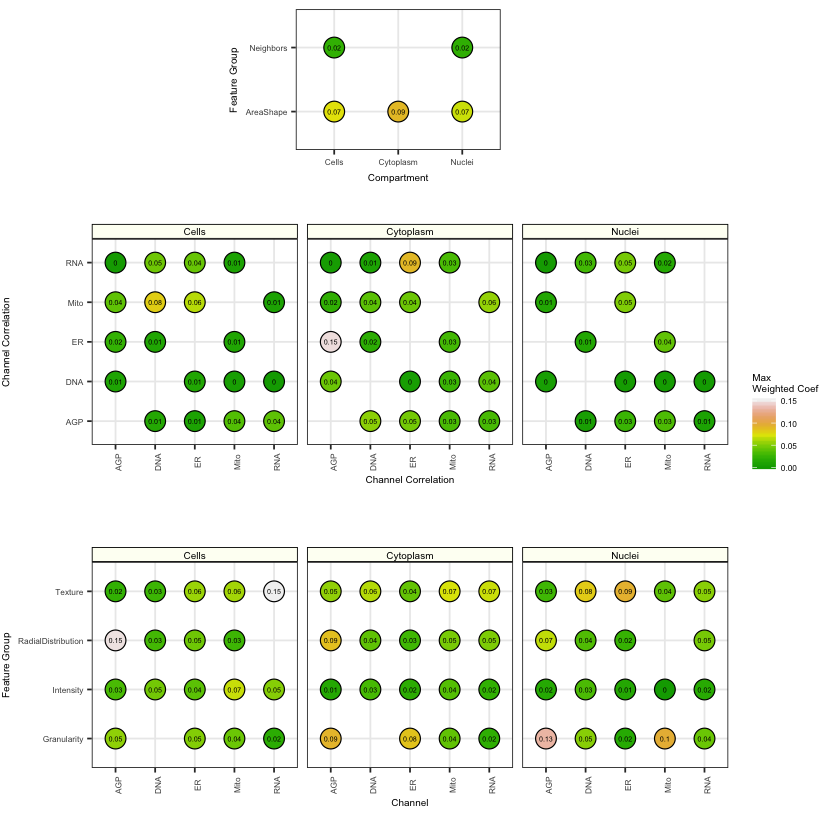

In [13]:
big_fig